# Advanced Lane Lines
## Udacity Self-Driving Car Engineer Program
#### Josh Smith
##### 2017/02/20

The goal of the project is the mark the lane boundarys in the video stream of a front center mounted camera in a car.  This workbook was created to allow for a simple walkthough of the code implemented in `lane_lines.py`.

To acomplish this the following topics will be covered:
* Camera Distortion Correction
* Perspective Transformations
* Lane Marking Detection
* Lane Line Fitting
* Road Curvature and Vehicle Offset Calculation
* Lane Projecting
* Video Processing

Each of these topics will cover the requirements found in the project [rubric](https://review.udacity.com/#!/rubrics/571/view).

## Import Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path
% matplotlib inline

## Camera Calibration
Lenses in cameras cause distortion in the image when the bend the light a little too much or not quite enough near the edges of the lense.  This distortion can be corrected by taking images of known objects and mapping distorted points to undistorted points.  Camera calibration was done using `opencv.calibrateCamera()`.  `calibrateCamera()` can automatically detect the intersections of our chessboard calibration target and generate our distortion correction factors.

![calibration_points](output_images/calibration_points.jpg "Corners Found")

Camera calibration is accomplished in lane_lines.py, lines 22-77

In [2]:
# Import the camera module
from lane_lines import Camera

# Construct the camera and run the calibration routine
camera = Camera()
if os.path.isfile(camera.calibration_file) & os.path.isfile(camera.transform_file):
    camera.load_calibration()
else:
    camera.calibrate(verbose=False)

Calibration Loaded


### Camera Calibration Results
Here we can examine the results of the camera calibration by viewing the original next to the undistorted image.

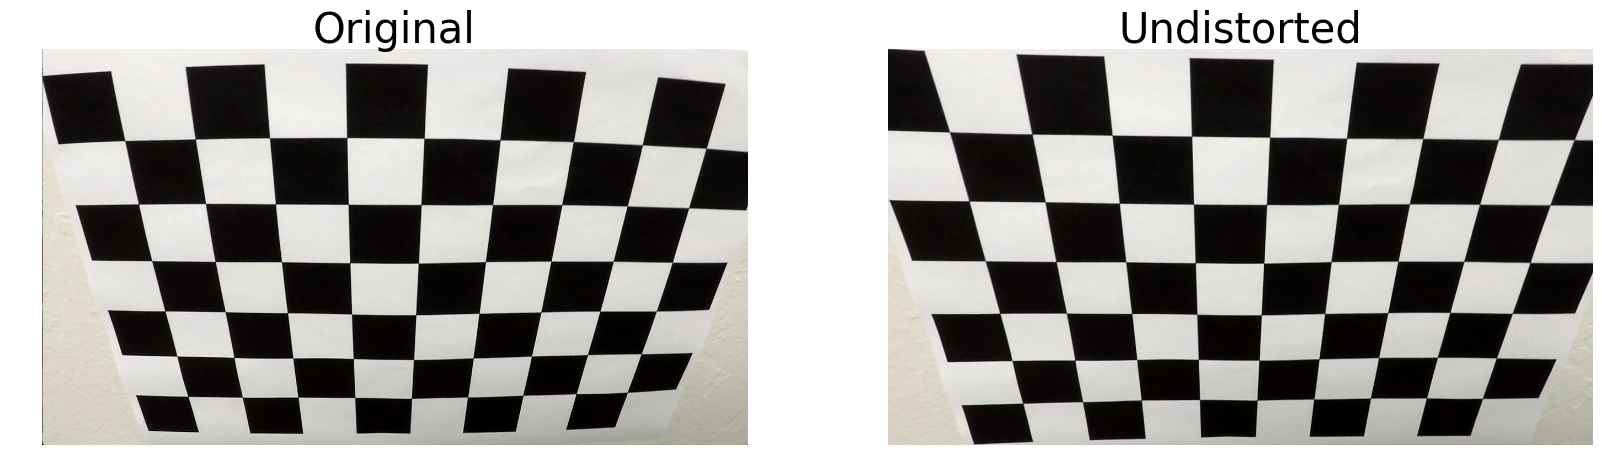

In [3]:
image = cv2.imread('camera_cal/calibration2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = camera.undistort(image)
from lane_lines import compare_image
compare_image(image, "Original", undistorted, "Undistorted")

### Perspective Transformation
Determine points for the perspective transformation from camera view to bird's eye view from above.
Here we can see the transformation area over the source and destination images.
The source and destination transform points were determined empirically.  I would like to work on an automated parameter calculation by determining the vanishing point from intersecting lines in the image using Canny edge detection and a Hough transform.

Image warping can be found in lane_lines.py lines 124-130

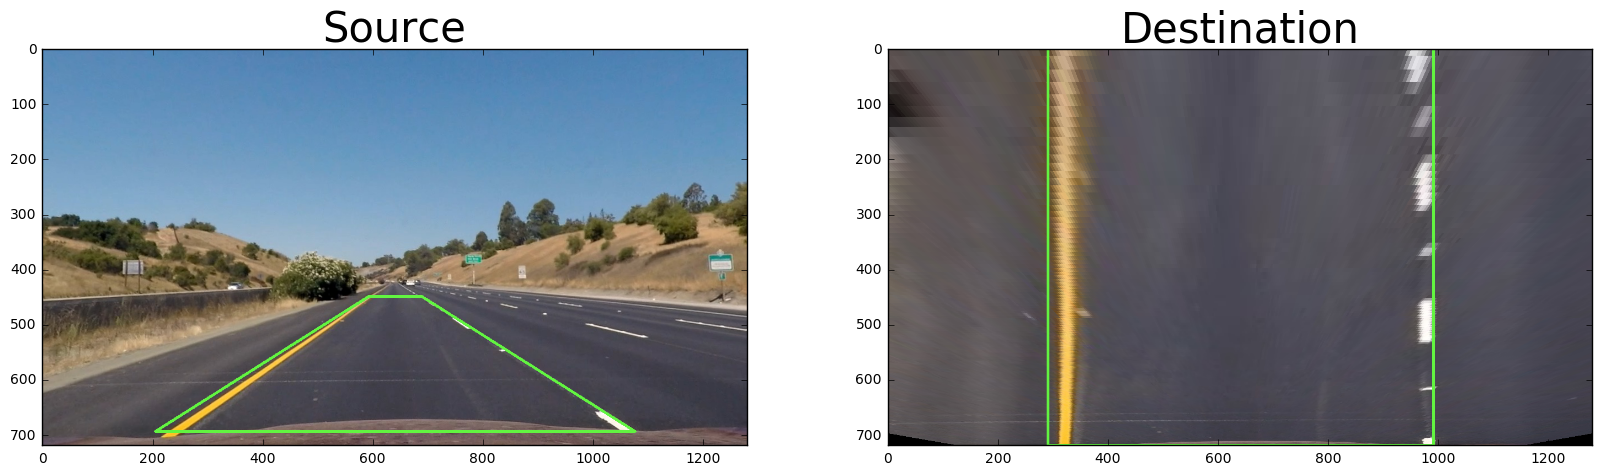

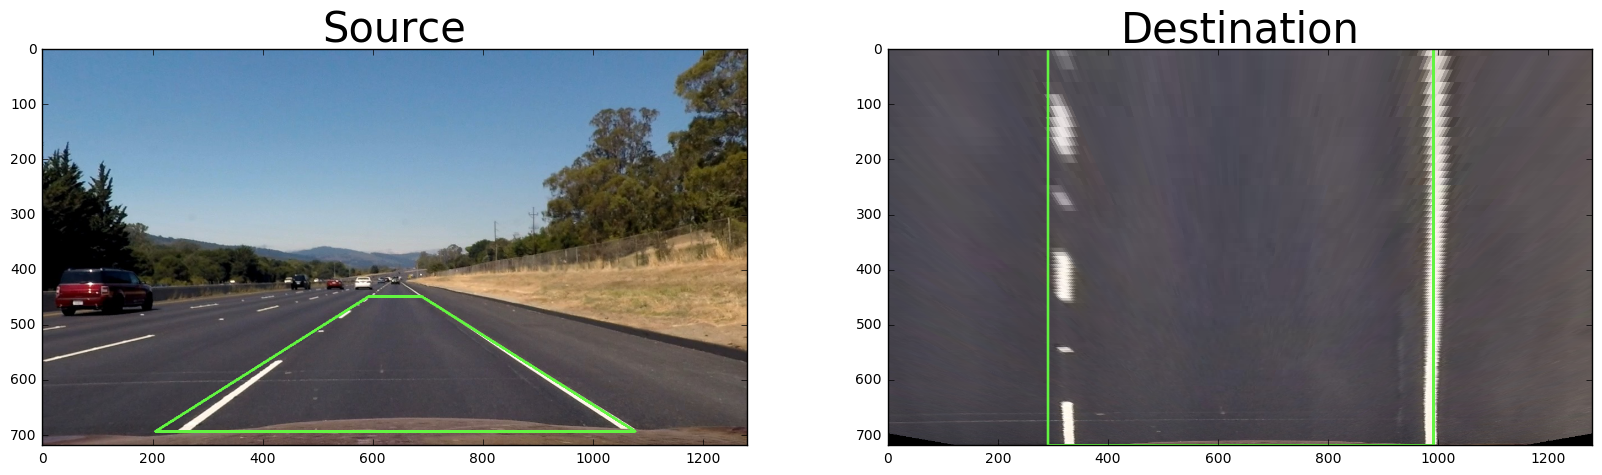

In [4]:
image1 = cv2.imread('test_images/straight_lines1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('test_images/straight_lines2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
images = [image1, image2]

# Source Points
center = 640
near_width = 870
far_width = 96
src = np.array([[center - near_width/2, 695.],
                [center + near_width/2, 695.],
                [center + far_width/2, 450.],
                [center - far_width/2, 450.]], np.float32)

# Destination Points
lane_width = 700
dst = np.array([[center - lane_width/2, 720.],
                [center + lane_width/2, 720.],
                [center + lane_width/2, 0.],
                [center - lane_width/2, 0.]], np.float32)

# Set perspective transformation points and calculate transformation matrices
camera.set_perspective_points(src, dst, images)

## Image Processing Pipeline

In [5]:
from lane_lines import LaneLines
# construct lane marker
lane = LaneLines((1280, 720), camera, (189, 26))

### Image Transformation
Warping the image from the perspective of the camera to a top-down perspective

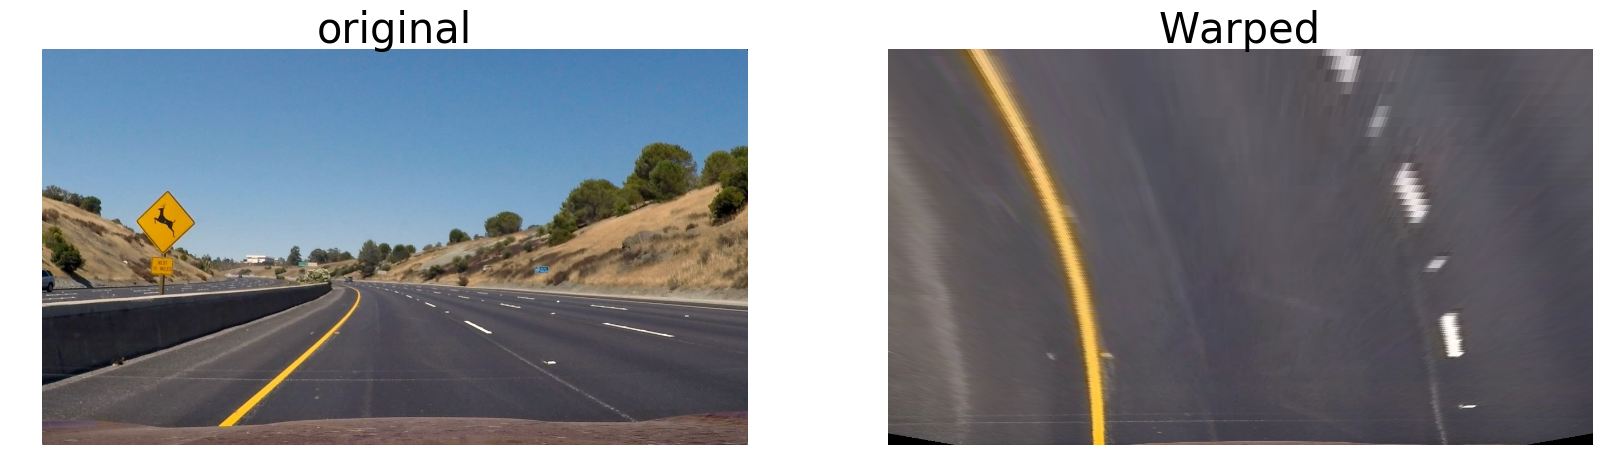

In [6]:
image = cv2.imread('test_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistort = camera.undistort(image)
warp = camera.warp(undistort)
compare_image(image, "original", warp, "Warped")

### Lane Pixel Extraction
Lane pixel extraction was accomplished by converting the image to HSL and using the following:
* Gradient on the L channel
* Gradient on the S channel
* Threshold on a histogram equalized S channel

These layers were cleaned using a series of dilation and erode to close regions and remove noise.

Code for this can be found in `lane_lines.py` lines 72-229

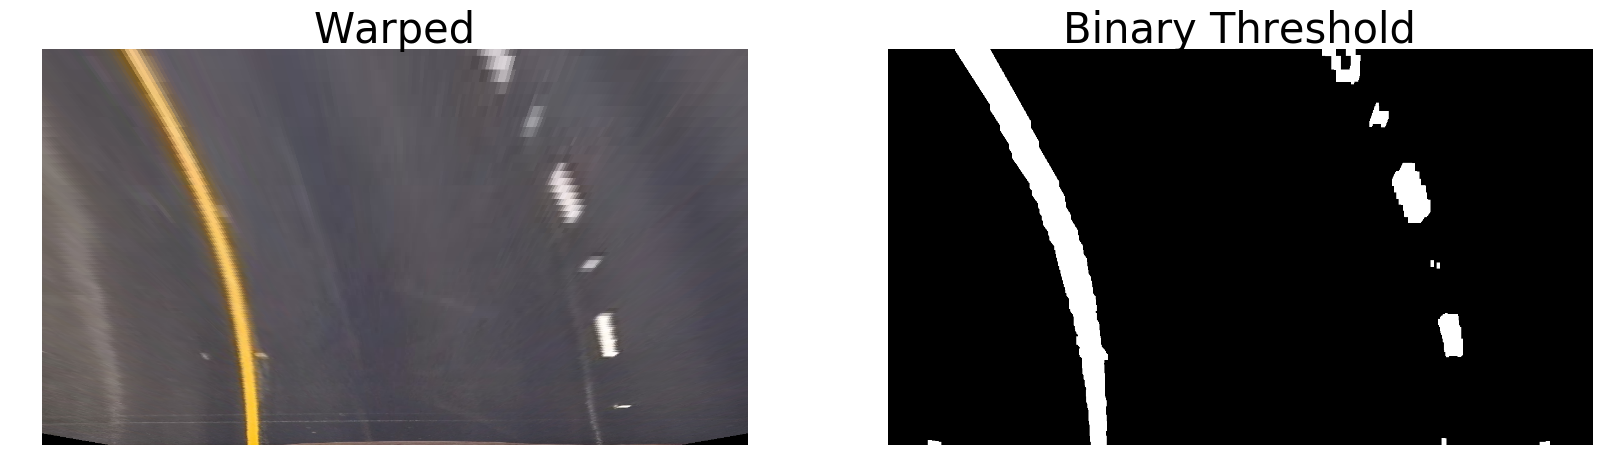

In [7]:
binary_image = lane.binary_image(warp)
compare_image(warp, "Warped", binary_image, "Binary Threshold")

### Identify Lane Lines and Fit Polynomial
Lane pixels are initially identified by taking a histogram of the lower half of the image.  Peaks in the left and right sides of the histogram were assumed to be the start of the lane markers.  A sliding window was then used to find the maximum pixel density in a slice of the image starting at the bottom.  The search for the next layer was centered over the maximum density from the layer below.  After the lane points were found a polynomial was fit to the candidate lane points found.  After a lane fit was accomplished a new search windows are created by using a window around each lane fit polynomial.

Code can be found in lane_lines.py, lines 230-333

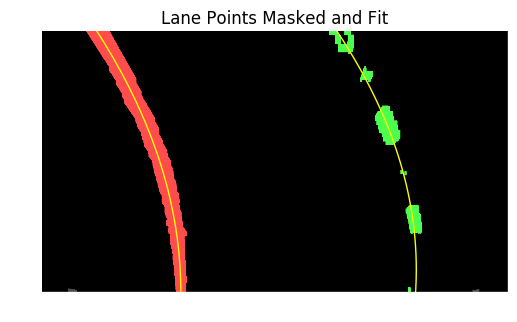

In [8]:
lane.find_lost_line_points(binary_image)
lane.fit_lines()
lane.line_mask(50)
lane.find_line_points(binary_image)
lane.fit_lines()
all_points = np.dstack((binary_image, binary_image, binary_image))*255
colored_lines = np.dstack((lane.left_points, lane.right_points, np.zeros_like(binary_image)))*255
result = cv2.addWeighted(colored_lines, 1, all_points, 0.3, 0)
plt.imshow(result)
plt.plot(lane.left_fitx, lane.ploty, color='yellow')
plt.plot(lane.right_fitx, lane.ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis('off')
plt.title('Lane Points Masked and Fit')
plt.show()

### Calculate the Radius of Curvature and Lane Offset
Using the fit equations for the left and right lane markers, calculate the radius of curvature and the offset of the vehicle from the center of the lane.  To convert from image dimensions to physical dimensions a conversion factor is applied to both the x and y directions of the image. 

Lane curvature and offset are accomplished in lane_lines.py, lines 335-347.

In [9]:
lane.lane_stats()
print("Left Radius\t % 6.0fm" % lane.left_curverad)
print("Right Radius\t % 6.0fm" % lane.right_curverad)
print("Vehicle Offset\t % 4.3fm" % lane.vehicle_offset)

Left Radius	    312m
Right Radius	    273m
Vehicle Offset	 -0.341m


### Project Lane on Original Image
Using the lane fit polynomials, the area between the left and right fit polynomials is filled then unwarped onto the original image.
Display the radii and offset.

Marking the lane and printing statistics can be found in lane_lines.py, lines 349-385.

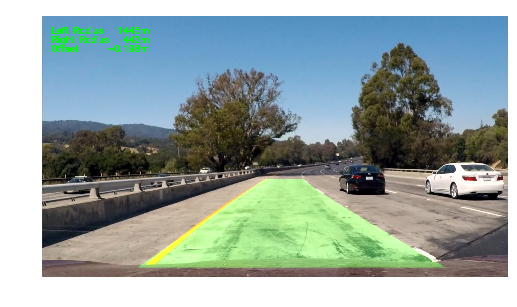

In [20]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lane.reset_lane()
plt.imshow(lane.mark_lane(image))
plt.axis('off')
plt.show()

## Process Video
Apply the processing pipeline to each frame of the video.

Processing the video is accomplished in lane_lines.py, lines 387-391

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
project_video = 'project_video.mp4'
lane.process_video(project_video)

[MoviePy] >>>> Building video output_videos/processed_project_video.mp4
[MoviePy] Writing video output_videos/processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:59<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/processed_project_video.mp4 



In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/processed_'+project_video))

## Conclusion
I'm very impressed with how well this implementation did on the main project video.  The output appears smooth and has no issues with tracking the lane through the changes in road color and shadowed regions.  My focus going forward would be in using some of the lanes physical characteristics to improve lane marking identification.  Tracking marking color, lane width, and multi lane patterns would all contribute to a more robust soltuion.  Ultimately I think that a neural network would perform this task with far greater accuracy than any of the algorithms that I would painstakingly construct.